In [3]:
import torch
import torch.nn as nn
import os

import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
sys.path.append('../')
import flowlib
import data_utils

import pdb

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

list_fn = '/mnt/lustre/share/panxingang/MPII/lists/train_lists_back_s2/temp.txt'

with open(list_fn, 'r') as f:
    fns = f.readlines()
fns = [fn.strip() for fn in fns]

In [4]:
def load_batch(idx, batch_size):
    img1_batch = []
    img2_batch = []
    flow_batch = []
    for i in range(batch_size):
        img1_fn, img2_fn, flowx_fn, flowy_fn = fns[idx + i].split()
        img1 = Image.open(img1_fn).convert('RGB')
        img2 = Image.open(img2_fn).convert('RGB')
        flowx = np.array(Image.open(flowx_fn)).astype(np.float32) / 255 * 100 - 50
        flowy = np.array(Image.open(flowy_fn)).astype(np.float32) / 255 * 100 - 50
        flow = np.concatenate((flowx[:,:,np.newaxis], flowy[:,:,np.newaxis]), axis=2)
        img1, img2, flow, ratio = data_utils.image_flow_resize(img1, img2, flow, short_size=320)
        flow = flow * ratio
        img1, img2, flow, _ = data_utils.image_flow_crop(img1, img2, flow, [256, 256], 'test')
        img1_batch.append(img1)
        img2_batch.append(img2)
        flow_batch.append(flow)
    return img1_batch, img2_batch, flow_batch

In [48]:
class WarpingLayer(nn.Module):
    def __init__(self, sort_flow, mask_th, n, h, w):
        super(WarpingLayer, self).__init__()
        self.sort_flow = sort_flow
        self.mask_th = mask_th
        
        self.meshx = torch.arange(w).view(1, 1, w).expand(n, h, w).contiguous().view(n, -1).cuda()
        self.meshy = torch.arange(h).view(1, h, 1).expand(n, h, w).contiguous().view(n, -1).cuda()
        #self.rangidx = torch.arange(h * w).view(1, -1).expand(n, h * w).cuda()
        self.warped_image = torch.zeros((n, 3, h, w), dtype=torch.float32).cuda()
        
    def forward(self, image, flow):
#         flow_for_grip = torch.zeros_like(flow)
#         flow_for_grip[:,0,:,:] = flow[:,0,:,:] / ((flow.size(3) - 1.0) / 2.0)
#         flow_for_grip[:,1,:,:] = flow[:,1,:,:] / ((flow.size(2) - 1.0) / 2.0)

#         torchHorizontal = torch.linspace(-1.0, 1.0, image.size(3)).view(1, 1, 1, image.size(3)).expand(image.size(0), 1, image.size(2), image.size(3))
#         torchVertical = torch.linspace(-1.0, 1.0, image.size(2)).view(1, 1, image.size(2), 1).expand(image.size(0), 1, image.size(2), image.size(3))
#         grid = torch.cat([torchHorizontal, torchVertical], 1)

        
        n, h, w = image.size(0), image.size(2), image.size(3)
        
        #flow = 10 * torch.ones((n, 2, h, w), dtype=torch.float32)
        #flow = flow / 1.5
        start = time.time()
        
        warped_meshx = self.meshx + flow[:,0,:,:].long().view(n, -1)
        warped_meshy = self.meshy + flow[:,1,:,:].long().view(n, -1)
        
        print("sum: {}".format(time.time() - start))
            
        start = time.time()    
        warped_meshx = torch.clamp(warped_meshx, 0, w - 1)
        warped_meshy = torch.clamp(warped_meshy, 0, h - 1)
        
        print("clamp: {}".format(time.time() - start))
        
        #start = time.time()
        #v = torch.sqrt(flow[:,0,:,:] ** 2 + flow[:,1,:,:] ** 2).view(n, -1)
        #print("sqrt: {}".format(time.time() - start))
        
        start = time.time()
#         if self.sort_flow:
#             v, sortidx = torch.sort(v, dim=1)
#         else:
            
        
        self.warped_image.zero_()
        #warped_image = image.clone()
        print("sort: {}".format(time.time() - start))
        
        start = time.time()
        for i in range(n):
#             sid = sortidx[i][v[i] > self.mask_th]
#             nid = torch.from_numpy(np.setdiff1d(np.arange(h * w), sid.cpu().numpy(), assume_unique=True)).cuda()
            #sid = (v[i] > self.mask_th)
            #nid = ~sid
            for c in range(3):
                #self.warped_image[i,c,self.meshy[i][nid],self.meshx[i][nid]] = image[i,c,self.meshy[i][nid],self.meshx[i][nid]]
                #self.warped_image[i,c,warped_meshy[i][sid],warped_meshx[i][sid]] = image[i,c,self.meshy[i][sid],self.meshx[i][sid]]
                self.warped_image[i,c,warped_meshy[i],warped_meshx[i]] = image[i,c,self.meshy[i],self.meshx[i]]
        print("copy: {}".format(time.time() - start))
        return self.warped_image

In [5]:
def reverse_flow(flow):
    n, h, w = flow.size(0), flow.size(2), flow.size(3)
    meshx = torch.arange(w).view(1, 1, w).expand(n, h, w).contiguous().view(n, -1).cuda()
    meshy = torch.arange(h).view(1, h, 1).expand(n, h, w).contiguous().view(n, -1).cuda()
    warped_meshx = meshx + flow[:,0,:,:].long().view(n, -1)
    warped_meshy = meshy + flow[:,1,:,:].long().view(n, -1)
    warped_meshx = torch.clamp(warped_meshx, 0, w - 1)
    warped_meshy = torch.clamp(warped_meshy, 0, h - 1)
    
    rev_flow = torch.zeros((n, 2, h, w), dtype=torch.float32).cuda()
    
    for i in range(n):
        rev_flow[i,:,warped_meshy[i],warped_meshx[i]] = -flow[i,:,meshy[i],meshx[i]]
        #rev_flow[i,1,warped_meshy[i],warped_meshx[i]] = -flow[i,1,meshy[i],meshx[i]]
    return rev_flow
    
def warp( x, flo):
        """
        warp an image/tensor (im2) back to im1, according to the optical flow
        x: [B, C, H, W] (im2)
        flo: [B, 2, H, W] flow
        """
        B, C, H, W = x.size()
        # mesh grid 
        xx = torch.arange(0, W).view(1,-1).repeat(H,1)
        yy = torch.arange(0, H).view(-1,1).repeat(1,W)
        xx = xx.view(1,1,H,W).repeat(B,1,1,1)
        yy = yy.view(1,1,H,W).repeat(B,1,1,1)
        grid = torch.cat((xx,yy),1).float()

        if x.is_cuda:
            grid = grid.cuda()
        vgrid = grid + flo

        # scale grid to [-1,1] 
        vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
        vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

        vgrid = vgrid.permute(0,2,3,1)        
        output = nn.functional.grid_sample(x, vgrid)
        mask = torch.ones(x.size()).cuda()
        mask = nn.functional.grid_sample(mask, vgrid)

        # if W==128:
            # np.save('mask.npy', mask.cpu().data.numpy())
            # np.save('warp.npy', output.cpu().data.numpy())
        
        mask[mask<0.9999] = 0
        mask[mask>0] = 1
        
        return (output*mask).cpu()

In [11]:
num = 39
idx = 0
img1_batch, img2_batch, flow_batch = load_batch(idx, num)
#model = WarpingLayer(False, 0, num, 256, 256).cuda()

start = time.time()
img1_tensor = torch.from_numpy(np.concatenate([np.array(img1).astype(np.float32).transpose((2,0,1))[np.newaxis,...] for img1 in img1_batch], axis=0))
img2_tensor = np.concatenate([np.array(img2).astype(np.float32).transpose((2,0,1))[np.newaxis,...] for img2 in img2_batch], axis=0)
flow_tensor = torch.from_numpy(np.concatenate([np.array(flow).astype(np.float32).transpose((2,0,1))[np.newaxis,...] for flow in flow_batch], axis=0))
#warped = model(img1_tensor.cuda(), flow_tensor.cuda()).cpu()
#rflow = reverse_flow(flow_tensor.cuda())
warped = warp(img1_tensor.cuda(), flow_tensor.cuda())
print("time: {}".format(time.time() - start))

print("Error: {}".format(np.fabs((img2_tensor - warped.numpy())).mean()))


time: 0.9189186096191406
Error: 16.291051864624023


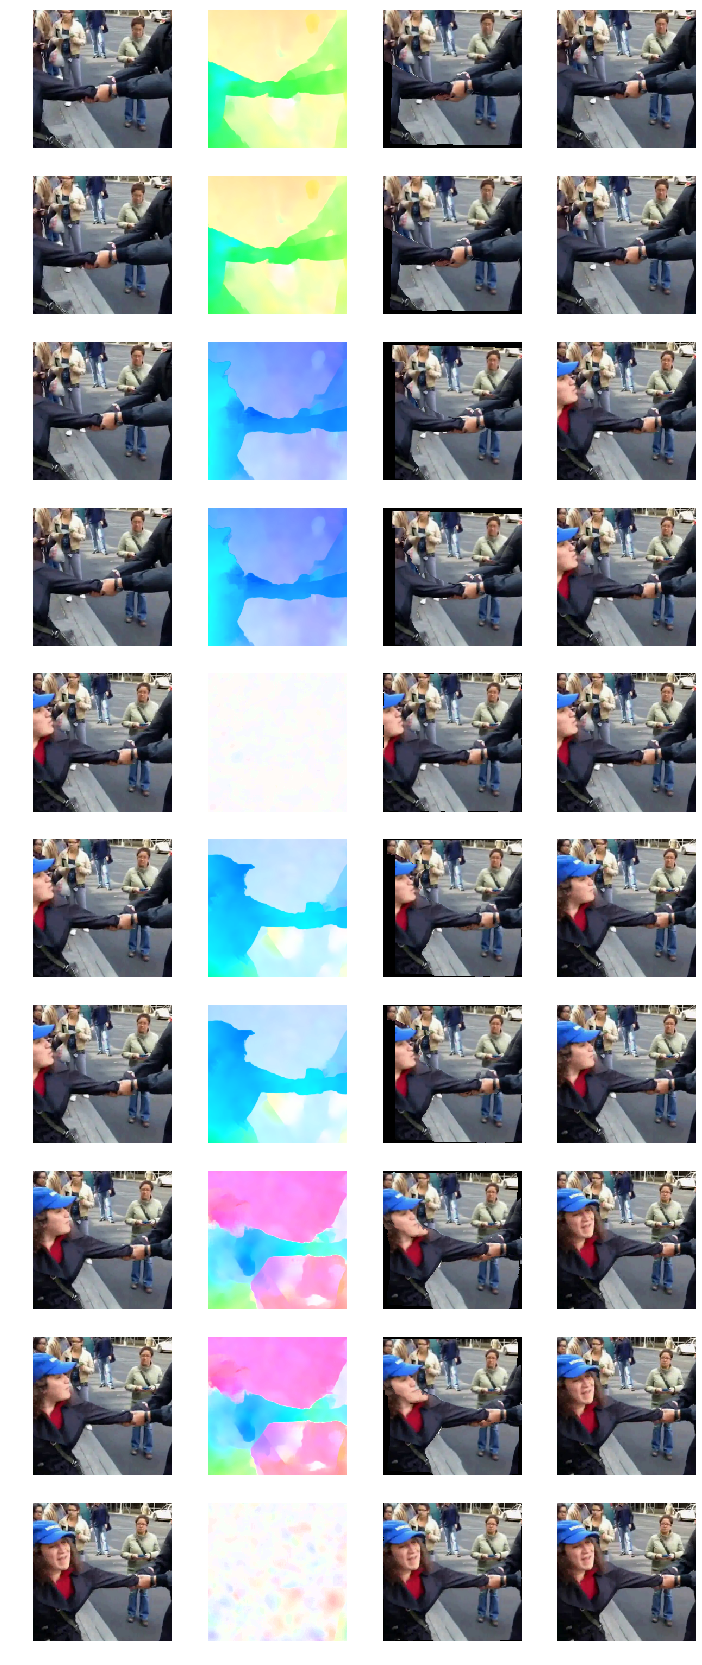

In [16]:
num = 10
start_idx = 10
rows = 10
cols = 4

plt.figure(figsize=(3 * cols, 3 * rows))
               
for i in range(num):
    plt.subplot(rows, cols, i * cols + 1)
    plt.imshow(img1_batch[start_idx+i])
    plt.axis('off')
    plt.subplot(rows, cols, i * cols + 2)
    #plt.imshow(flowlib.flow_to_image(rflow.cpu().numpy()[start_idx+i].transpose((1,2,0))))
    plt.imshow(flowlib.flow_to_image(flow_batch[start_idx+i]))
    plt.axis('off')
    plt.subplot(rows, cols, i * cols + 3)
    plt.imshow(warped[start_idx+i].numpy().transpose((1,2,0)).astype(np.uint8))
    plt.axis('off')
    plt.subplot(rows, cols, i * cols + 4)
    plt.imshow(img2_batch[start_idx+i])
    plt.axis('off')
plt.show()

In [24]:
print(rflow.cpu().numpy())

9.447779
